# Controls

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import segmentation_models_pytorch as smp
import random
from torchsummary import summary
 
# Define paths and parameters
data_dir = '/user/HS402/rk01219/Downloads/Segmentation/archive/Brain Tumor Segmentation Dataset'
image_dir = os.path.join(data_dir, 'image')  # Directory containing all tumor images
mask_dir = os.path.join(data_dir, 'mask')    # Directory containing corresponding masks
batch_size = 4 # Number of samples per batch
num_epochs = 200   # Number of training epochs
learning_rate = 0.0005  # Learning rate for the optimizer
val_size = 0.2  # Proportion of data to be used for validation
test_size = 0.1  # Proportion of data to be used for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise use CPU
model_save_path = 'unet++_model.pth'  # Specify the save location for the model

# Choose the loss function and optimizer
loss_name = 'combined'  # Options: 'ce' (Cross-Entropy), 'dice' (Dice Loss), 'combined' (CE + Dice)
optimizer_name = 'sgd'  # Options: 'adam', 'sgd',

# Choose the model
model_name = 'manet'  # Options: 'manet', 'unet', 'unetplusplus', 'deeplabv3'
in_channels = 1  # Number of input channels (1 for grayscale images)
num_classes = 4  # Number of classes for segmentation (4 for multi-class segmentation)
encoder_name = 'resnet50'  # Encoder backbone (ResNet50 in this case)

# Define transformations for training (applied to grayscale images)
base_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Randomly crop the image, with a scale range
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply random affine transformations
])

# Transformations specific to the images
image_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the tensor (mean=0.5, std=0.5)
])

# Transformations specific to the masks
mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert mask to PyTorch tensor
])

class JointTransform:
    def __init__(self, base_transform, image_transform, mask_transform):
        self.base_transform = base_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, img, mask):
        # Apply the same base transformations to both the image and mask
        seed = torch.seed()  # Ensure the same random seed is used for both transforms
        torch.manual_seed(seed)
        img = self.base_transform(img)

        torch.manual_seed(seed)
        mask = self.base_transform(mask)

        # Apply image-specific transformations
        img = self.image_transform(img)

        # Apply mask-specific transformations
        mask = self.mask_transform(mask)

        return img, mask

# Instantiate the JointTransform
joint_transform = JointTransform(base_transform, image_transform, mask_transform)

# Define transformations for the test set
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to PyTorch tensor
])


# DataLoader

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, joint_transform=None, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        self.images = []
        self.masks = []
        
        for cls in ['0', '1', '2', '3']:  # Iterate over each class directory
            cls_img_dir = os.path.join(image_dir, cls)
            cls_mask_dir = os.path.join(mask_dir, cls)
            
            cls_images = sorted([img for img in os.listdir(cls_img_dir) if os.path.isfile(os.path.join(cls_img_dir, img))])
            cls_masks = sorted([mask for mask in os.listdir(cls_mask_dir) if os.path.isfile(os.path.join(cls_mask_dir, mask))])
            
            # Ensure images and masks are aligned
            for img in cls_images:
                base_name = img.split('.')[0]
                mask_name = f"{base_name}_m.jpg"
                img_path = os.path.join(cls_img_dir, img)
                mask_path = os.path.join(cls_mask_dir, mask_name)
                
                if os.path.exists(mask_path):
                    self.images.append(img_path)
                    self.masks.append(mask_path)
                else:
                    print(f"No corresponding mask found for image: {img_path}")
                    raise ValueError(f"No corresponding mask found for image: {img_path}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        mask_name = self.masks[idx]
        image = Image.open(img_name).convert("L")  # Load image as grayscale
        mask = Image.open(mask_name).convert("L")  # Load mask as grayscale

        # Apply joint transformations (if provided)
        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)
        
        # Apply image-specific transformations (only if the image is still a PIL Image)
        if self.image_transform and isinstance(image, Image.Image):
            image = self.image_transform(image)
        
        # Apply mask-specific transformations (only if the mask is still a PIL Image)
        if self.mask_transform and isinstance(mask, Image.Image):
            mask = self.mask_transform(mask)

        return image, mask

# Instantiate the dataset for training and validation with full transformations
train_dataset = CustomDataset(image_dir, mask_dir, joint_transform=joint_transform, image_transform=image_transform, mask_transform=mask_transform)


test_dataset =CustomDataset(image_dir, mask_dir, joint_transform=joint_transform, image_transform=image_transform, mask_transform=mask_transform)
# Instantiate the dataset for the test set with only resize and tensor conversion
# test_dataset = CustomDataset(image_dir, mask_dir, joint_transform=None, image_transform=test_transform, mask_transform=test_transform)

# Function to print random image and mask pairs to verify alignment
def print_random_image_mask_pairs(dataset, num_samples=10):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    for i in range(min(num_samples, len(dataset))):
        idx = indices[i]
        img_name = os.path.basename(dataset.images[idx])
        mask_name = os.path.basename(dataset.masks[idx])
        print(f"Image: {img_name}, Mask: {mask_name}")

# Print some random image and mask pairs to verify alignment
print_random_image_mask_pairs(train_dataset, num_samples=10)

# Split the dataset into train, validation, and test sets
num_train = len(train_dataset)
split_idx_test = int(num_train * test_size)  # 10% for test
split_idx_val = int(num_train * val_size)  # 20% for validation
split_idx_train = num_train - split_idx_test - split_idx_val  # Remaining for training

# Use random_split to create training, validation, and test sets
train_data, val_data, test_data = random_split(train_dataset, [split_idx_train, split_idx_val, split_idx_test])

# Create dataloaders for each dataset split
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Print the number of images in each dataset split
print(f"Number of images in the training set: {len(train_data)}")
print(f"Number of images in the validation set: {len(val_data)}")
print(f"Number of images in the test set: {len(test_data)}")


Image: Tr-pi_0662.jpg, Mask: Tr-pi_0662_m.jpg
Image: Tr-gl_1183.jpg, Mask: Tr-gl_1183_m.jpg
Image: Tr-me_0290.jpg, Mask: Tr-me_0290_m.jpg
Image: Tr-me_0222.jpg, Mask: Tr-me_0222_m.jpg
Image: Tr-no_0439.jpg, Mask: Tr-no_0439_m.jpg
Image: Tr-no_0979.jpg, Mask: Tr-no_0979_m.jpg
Image: Tr-no_1306.jpg, Mask: Tr-no_1306_m.jpg
Image: Tr-no_0867.jpg, Mask: Tr-no_0867_m.jpg
Image: Tr-pi_0266.jpg, Mask: Tr-pi_0266_m.jpg
Image: Tr-pi_0903.jpg, Mask: Tr-pi_0903_m.jpg
Number of images in the training set: 2967
Number of images in the validation set: 847
Number of images in the test set: 423


Visualizing Training Samples


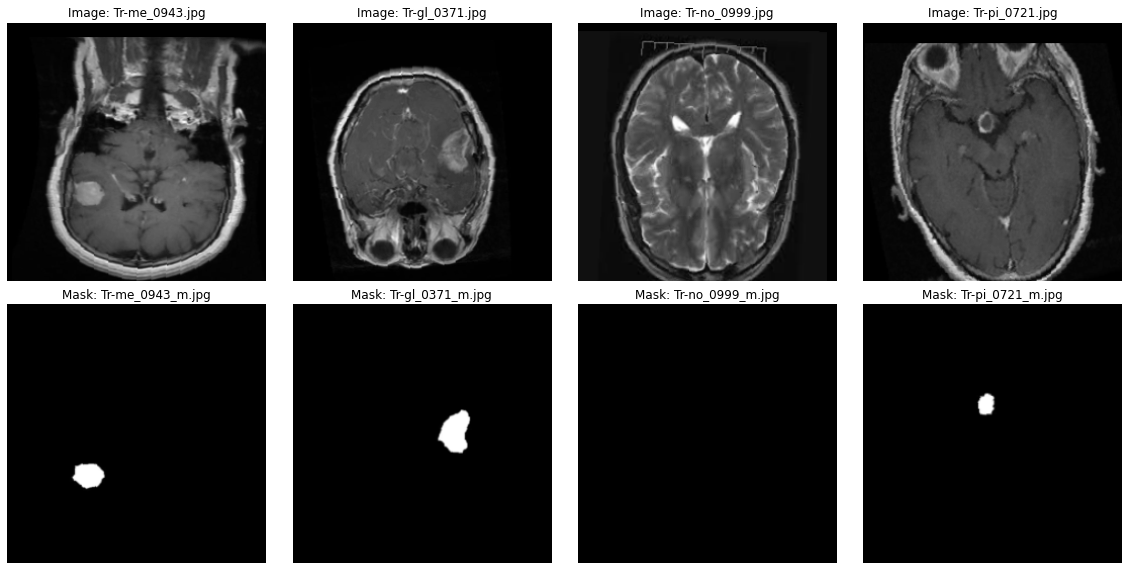

Visualizing Validation Samples


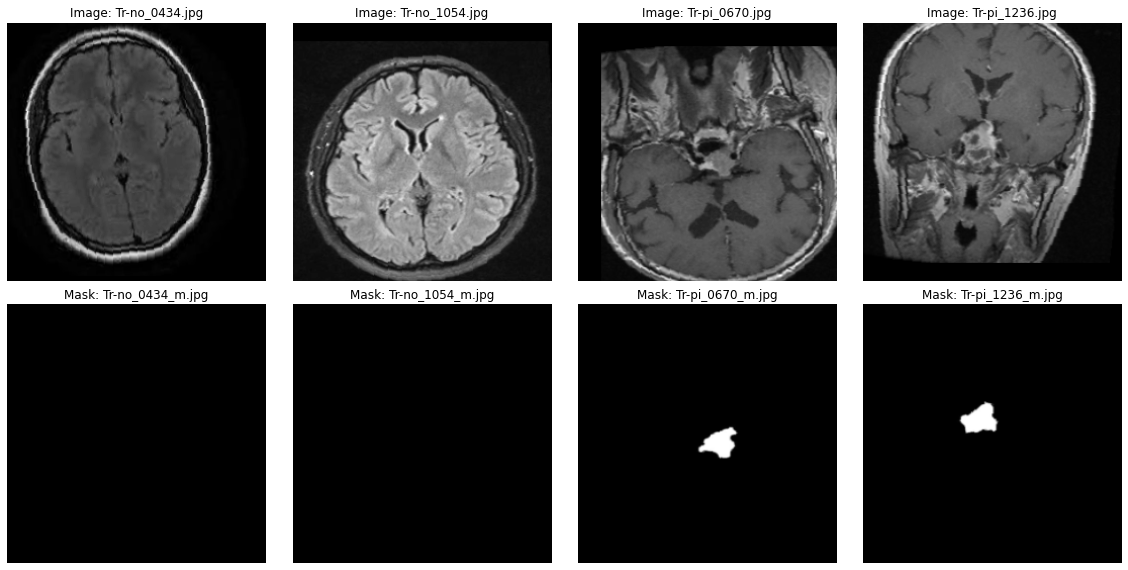

Visualizing Test Samples


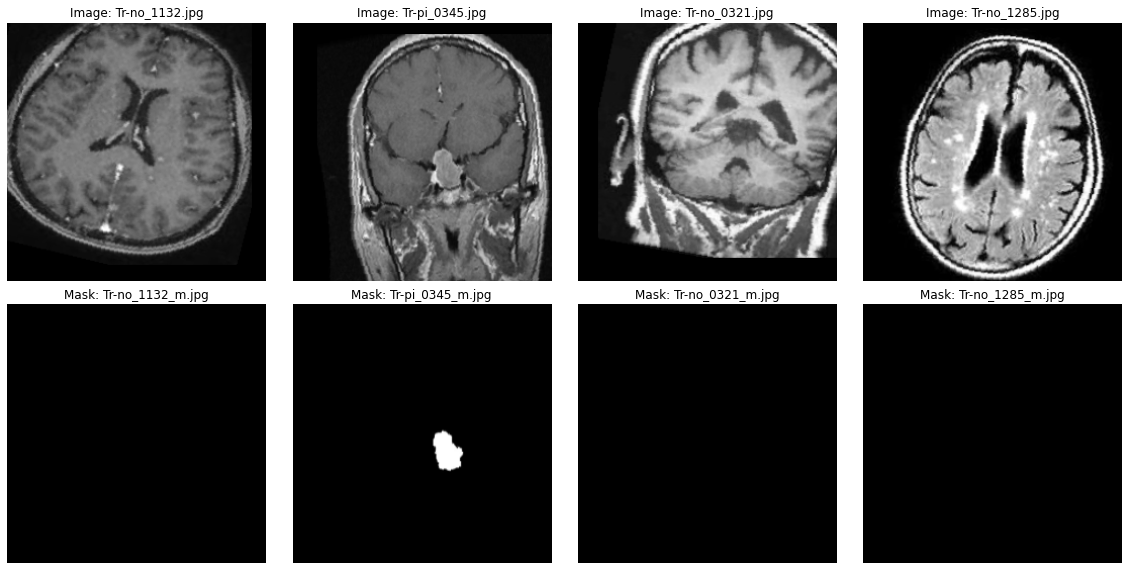

In [3]:
import matplotlib.pyplot as plt
import random
import os

def visualize_random_samples(data_loader, original_dataset, num_samples=4, image_size=(4, 8)):
    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * image_size[0], image_size[1]))
    
    for i in range(num_samples):
        # Determine the original index if the DataLoader uses a subset
        if isinstance(data_loader.dataset, torch.utils.data.Subset):
            original_idx = data_loader.dataset.indices[random.randint(0, len(data_loader.dataset) - 1)]
        else:
            original_idx = random.randint(0, len(data_loader.dataset) - 1)
        
        # Retrieve the image and mask using the original index (no further transformation needed)
        image, mask = original_dataset[original_idx]
        
        # Convert tensor to numpy array for visualization
        image = image.squeeze().cpu().numpy()  # Convert image tensor to numpy array
        mask = mask.squeeze().cpu().numpy()  # Convert mask tensor to numpy array
        
        # Get the filenames for display
        image_name = os.path.basename(original_dataset.images[original_idx])
        mask_name = os.path.basename(original_dataset.masks[original_idx])
        
        # Display the image in the top row
        axs[0, i].imshow(image, cmap='gray')
        axs[0, i].set_title(f'Image: {image_name}')
        axs[0, i].axis('off')
        
        # Display the corresponding mask in the bottom row
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].set_title(f'Mask: {mask_name}')
        axs[1, i].axis('off')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Visualize random samples from the training set
print("Visualizing Training Samples")
visualize_random_samples(train_loader, train_dataset, num_samples=4, image_size=(4, 8))

# Visualize random samples from the validation set
print("Visualizing Validation Samples")
visualize_random_samples(val_loader, train_dataset, num_samples=4, image_size=(4, 8))

# Visualize random samples from the test set
print("Visualizing Test Samples")
visualize_random_samples(test_loader, test_dataset, num_samples=4, image_size=(4, 8))


# Model Selection

In [4]:
import segmentation_models_pytorch as smp
from torchsummary import summary

# Define MAnet model
def get_manet(in_channels, num_classes, encoder_name):
    return smp.MAnet(
        encoder_name=encoder_name,  # Encoder backbone
        encoder_weights='imagenet', # Pre-trained on ImageNet
        encoder_depth=5,
        decoder_use_batchnorm=True,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_pab_channels=64,
        in_channels=in_channels,
        classes=num_classes,
        activation=None
    )

# Define Unet model
def get_unet(in_channels, num_classes, encoder_name):
    return smp.Unet(
        encoder_name=encoder_name,
        encoder_weights='imagenet',
        in_channels=in_channels,
        classes=num_classes
    )

# Define UnetPlusPlus model
def get_unetplusplus(in_channels, num_classes, encoder_name):
    return smp.UnetPlusPlus(
        encoder_name=encoder_name,
        encoder_weights='imagenet',
        in_channels=in_channels,
        classes=num_classes
    )

# Define DeepLabV3 model
def get_deeplabv3(in_channels, num_classes, encoder_name):
    return smp.DeepLabV3(
        encoder_name=encoder_name,
        encoder_weights='imagenet',
        in_channels=in_channels,
        classes=num_classes
    )

# Function to get the model
def get_model(model_name, in_channels, num_classes, device, encoder_name='resnet50'):
    if model_name == "manet":
        model = get_manet(in_channels, num_classes, encoder_name)
    elif model_name == "unet":
        model = get_unet(in_channels, num_classes, encoder_name)
    elif model_name == "unetplusplus":
        model = get_unetplusplus(in_channels, num_classes, encoder_name)
    elif model_name == "deeplabv3":
        model = get_deeplabv3(in_channels, num_classes, encoder_name)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    return model

# Get the model
model = get_model(model_name, in_channels, num_classes, device, encoder_name)

# Move model to GPU if available
model = model.to(device)

# Print model summary
summary(model, input_size=(in_channels, 256, 256), device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

# Optimizer and loss function

In [5]:
import torch.nn as nn
import segmentation_models_pytorch as smp

# Separate loss functions
ce_loss = nn.CrossEntropyLoss()  # Cross-Entropy Loss
dice_loss = smp.losses.DiceLoss(mode='multiclass')  # Dice Loss

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, ce_weight=1.0, dice_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.ce_loss = ce_loss
        self.dice_loss = dice_loss
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight

    def forward(self, outputs, masks):
        ce_loss = self.ce_loss(outputs, masks.long())
        dice_loss = self.dice_loss(outputs, masks)
        return self.ce_weight * ce_loss + self.dice_weight * dice_loss

# Function to select the loss function
def get_loss_function(loss_name):
    if loss_name == 'ce':
        return ce_loss
    elif loss_name == 'dice':
        return dice_loss
    elif loss_name == 'combined':
        return CombinedLoss(ce_weight=1.0, dice_weight=1.0)
    else:
        raise ValueError(f"Unsupported loss function: {loss_name}")

# Function to select the optimizer
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Initialize the chosen loss function
criterion = get_loss_function(loss_name)

# Initialize the chosen optimizer
optimizer = get_optimizer(optimizer_name, model, learning_rate)


In [6]:
# Check shapes after applying transforms

# Get all files in the directory, filtering out directories
image_files = [f for f in sorted(os.listdir(os.path.join(image_dir, '0'))) if os.path.isfile(os.path.join(image_dir, '0', f))]
mask_files = [f for f in sorted(os.listdir(os.path.join(mask_dir, '0'))) if os.path.isfile(os.path.join(mask_dir, '0', f))]

# Load the first image and mask from the filtered lists
image = Image.open(os.path.join(image_dir, '0', image_files[0])).convert("L")
mask = Image.open(os.path.join(mask_dir, '0', mask_files[0])).convert("L")

# Apply joint transformation (if available)
if joint_transform:
    image, mask = joint_transform(image, mask)

# Apply individual transformations (make sure these work on PIL Images)
if image_transform and isinstance(image, Image.Image):
    image = image_transform(image)
if mask_transform and isinstance(mask, Image.Image):
    mask = mask_transform(mask)

# Check if the transformations converted the images to tensors
if isinstance(image, torch.Tensor):
    print(f"Transformed image is already a tensor with shape: {image.shape}")
else:
    print(f"Transformed image shape: {image.size}")  # PIL Image

if isinstance(mask, torch.Tensor):
    print(f"Transformed mask is already a tensor with shape: {mask.shape}")
else:
    print(f"Transformed mask shape: {mask.size}")  # PIL Image


Transformed image is already a tensor with shape: torch.Size([1, 256, 256])
Transformed mask is already a tensor with shape: torch.Size([1, 256, 256])


# Metrics


In [7]:
def calculate_iou(pred, target, num_classes=4, epsilon=1e-6):
    pred = torch.argmax(pred, dim=1)
    iou_per_class = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        iou = intersection / (union + epsilon) if union != 0 else torch.tensor(0.0)
        iou_per_class.append(iou.item())
    return sum(iou_per_class) / num_classes

def calculate_dice(pred, target, num_classes=4, epsilon=1e-6):
    pred = torch.argmax(pred, dim=1)
    dice_per_class = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        dice = (2.0 * intersection) / (pred_cls.sum() + target_cls.sum() + epsilon) if (pred_cls.sum() + target_cls.sum()) != 0 else torch.tensor(0.0)
        dice_per_class.append(dice.item())
    return sum(dice_per_class) / num_classes

def calculate_accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)
    correct = (pred == target).float().sum()
    total = target.numel()
    accuracy = correct / total
    return accuracy.item()


In [8]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_intersection_iou = 0.0
    total_union_iou = 0.0
    total_intersection_dice = 0.0
    total_sum_dice = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device).squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks.long())
            total_loss += loss.item() * images.size(0)

            pred = torch.argmax(outputs, dim=1).float()
            target = masks.float()

            intersection = (pred * target).sum()
            union = pred.sum() + target.sum() - intersection
            total_intersection_iou += intersection
            total_union_iou += union

            total_intersection_dice += intersection
            total_sum_dice += pred.sum() + target.sum()

            total_correct += (pred == target).float().sum().item()
            total_pixels += target.numel()

    avg_loss = total_loss / len(data_loader.dataset)
    avg_iou = total_intersection_iou / (total_union_iou + 1e-6)
    avg_dice = (2.0 * total_intersection_dice) / (total_sum_dice + 1e-6)
    avg_accuracy = total_correct / total_pixels

    return avg_loss, avg_iou.item(), avg_dice.item(), avg_accuracy


Epoch [1/200], Train Loss: 0.4163, Train IoU: 0.0115, Train Dice: 0.0227, Train Accuracy: 0.9532, Val Loss: 0.3006, Val IoU: 0.0000, Val Dice: 0.0000, Val Accuracy: 0.9839
Epoch [2/200], Train Loss: 0.2849, Train IoU: 0.0000, Train Dice: 0.0000, Train Accuracy: 0.9845, Val Loss: 0.2724, Val IoU: 0.0000, Val Dice: 0.0000, Val Accuracy: 0.9840
Epoch [3/200], Train Loss: 0.2206, Train IoU: 0.1766, Train Dice: 0.3002, Train Accuracy: 0.9857, Val Loss: 0.1623, Val IoU: 0.4089, Val Dice: 0.5805, Val Accuracy: 0.9876
Epoch [4/200], Train Loss: 0.1317, Train IoU: 0.4656, Train Dice: 0.6353, Train Accuracy: 0.9888, Val Loss: 0.1178, Val IoU: 0.5353, Val Dice: 0.6973, Val Accuracy: 0.9893
Epoch [5/200], Train Loss: 0.1108, Train IoU: 0.5109, Train Dice: 0.6763, Train Accuracy: 0.9895, Val Loss: 0.1196, Val IoU: 0.4221, Val Dice: 0.5936, Val Accuracy: 0.9887
Epoch [6/200], Train Loss: 0.0957, Train IoU: 0.5393, Train Dice: 0.7007, Train Accuracy: 0.9900, Val Loss: 0.0933, Val IoU: 0.5625, Val Dic

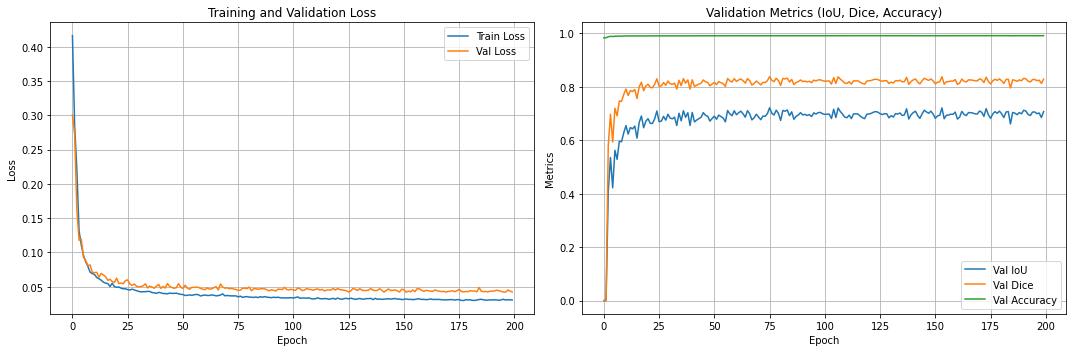

In [9]:
# Initialize lists to store training and validation metrics
train_losses = []
train_ious = []
train_dices = []
train_accuracies = []
val_losses = []
val_ious = []
val_dices = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_intersection_iou = 0.0
    total_union_iou = 0.0
    total_intersection_dice = 0.0
    total_sum_dice = 0.0
    total_correct = 0
    total_pixels = 0

    # Training phase
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device).squeeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        # Calculate intersections, unions, and accuracy for this batch
        pred = torch.argmax(outputs, dim=1).float()
        target = masks.float()

        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        total_intersection_iou += intersection
        total_union_iou += union

        total_intersection_dice += intersection
        total_sum_dice += pred.sum() + target.sum()

        # Accuracy
        total_correct += (pred == target).float().sum().item()
        total_pixels += target.numel()

    # Calculate epoch-level averages
    epoch_loss = running_loss / len(train_data)
    epoch_iou = total_intersection_iou / (total_union_iou + 1e-6)
    epoch_dice = (2.0 * total_intersection_dice) / (total_sum_dice + 1e-6)
    epoch_accuracy = total_correct / total_pixels

    # Validation phase
    val_loss, val_iou, val_dice, val_accuracy = evaluate_model(model, val_loader, criterion, device)

    # Store metrics for plotting
    train_losses.append(epoch_loss)
    train_ious.append(epoch_iou.item())
    train_dices.append(epoch_dice.item())
    train_accuracies.append(epoch_accuracy)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)
    val_accuracies.append(val_accuracy)

    # Print metrics after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train Dice: {epoch_dice:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully at {model_save_path}!")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation loss curves on the first subplot
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.grid(True)

# Plotting validation metrics (IoU, Dice, Accuracy) curves on the second subplot
ax2.plot(val_ious, label='Val IoU')
ax2.plot(val_dices, label='Val Dice')
ax2.plot(val_accuracies, label='Val Accuracy')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Metrics')
ax2.legend(loc='lower right')
ax2.set_title('Validation Metrics (IoU, Dice, Accuracy)')
ax2.grid(True)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()


In [10]:
# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved successfully at {model_save_path}!")



Model saved successfully at unet++_model.pth!


In [11]:

# Load and evaluate the model on the test set
model.load_state_dict(torch.load(model_save_path))
test_loss, test_iou, test_dice, test_accuracy = evaluate_model(model, test_loader, criterion, device)

# Print test metrics
print(f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.0400, Test IoU: 0.7259, Test Dice: 0.8412, Test Accuracy: 0.9921


# Visulization 

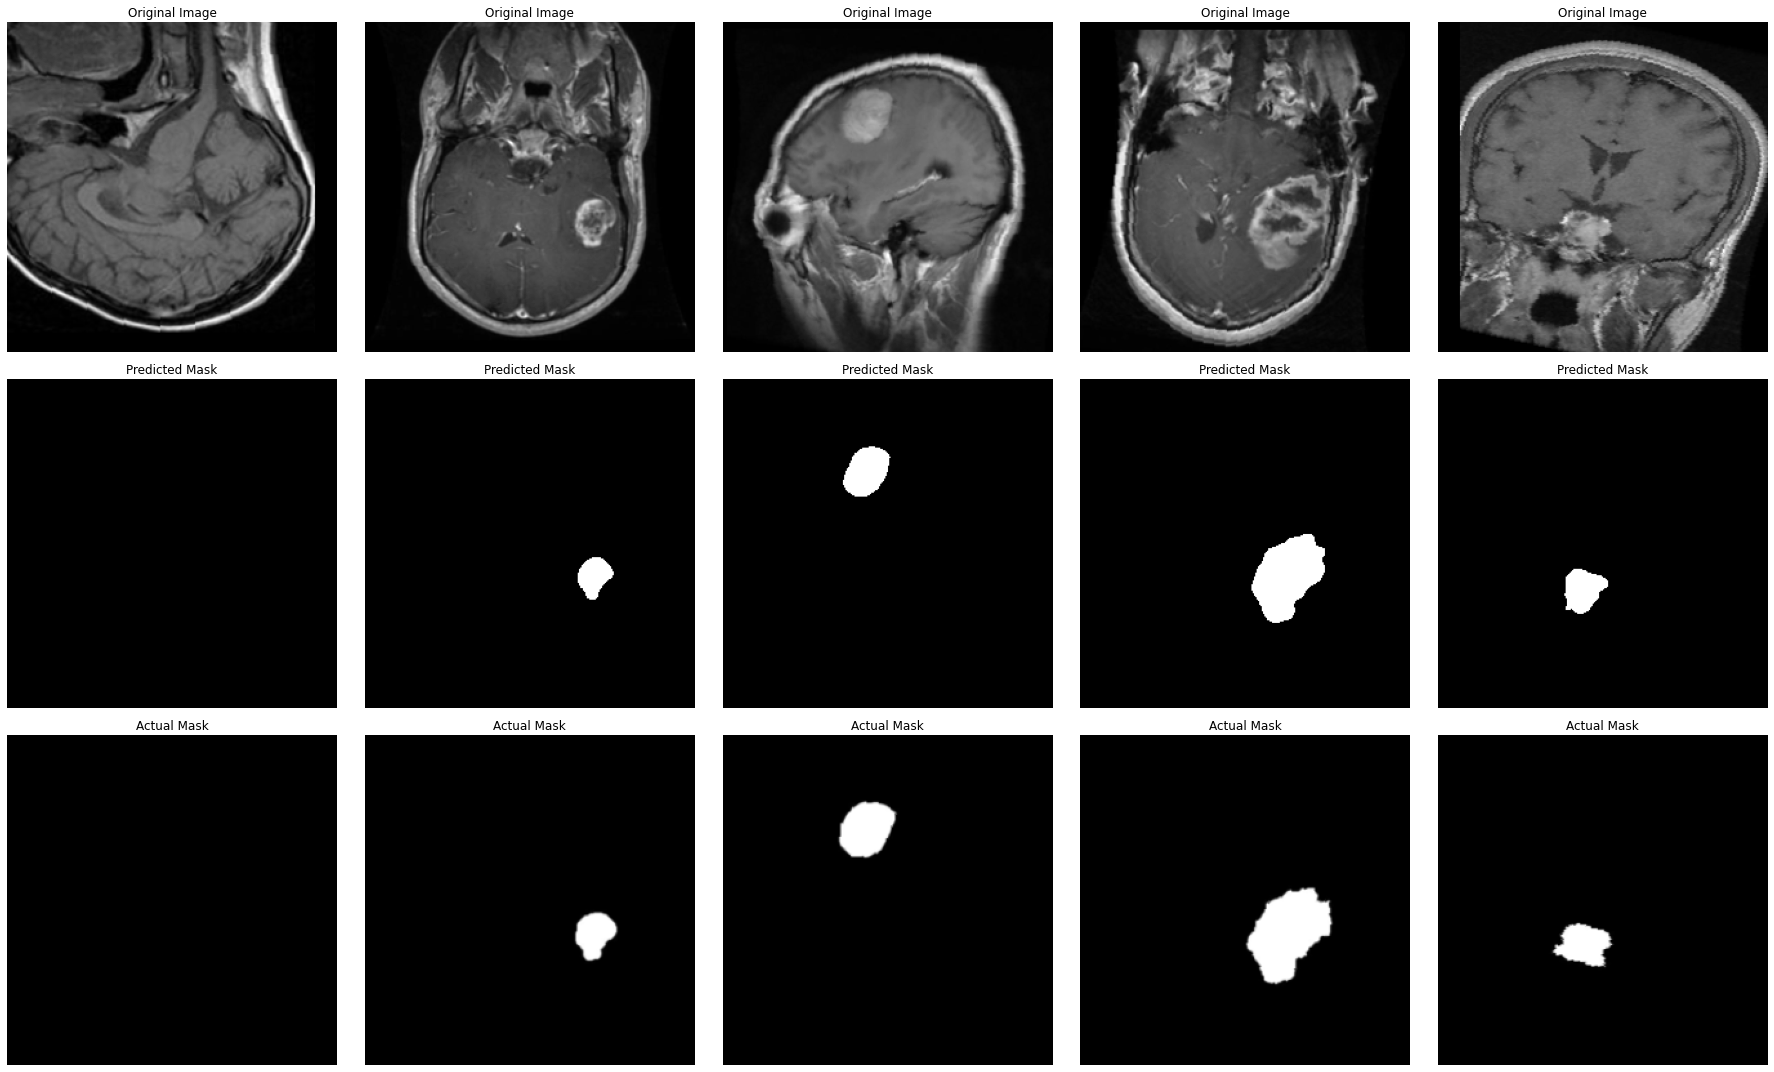

In [12]:
# Function to visualize random predictions
def visualize_random_predictions(model, dataset, device, num_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    with torch.no_grad():
        # Create a figure with three rows: images, predicted masks, and actual masks
        fig, axes = plt.subplots(3, num_images, figsize=(num_images * 5, 15))  # 3 rows, num_images columns
        
        for i, idx in enumerate(indices):
            # Load image and mask from dataset
            image, mask = dataset[idx]
            image = image.unsqueeze(0).to(device)
            
            # Predict mask
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()  # Get the class with the highest probability
            
            # Convert tensors to numpy arrays
            image_np = image.squeeze().cpu().numpy()
            mask_np = mask.squeeze().cpu().numpy()
            
            # Plot the original image in the first row
            axes[0, i].imshow(image_np, cmap='gray')
            axes[0, i].set_title('Original Image')
            axes[0, i].axis('off')
            
            # Plot the predicted mask in the second row
            axes[1, i].imshow(pred_mask, cmap='gray')
            axes[1, i].set_title('Predicted Mask')
            axes[1, i].axis('off')
            
            # Plot the actual mask in the third row
            axes[2, i].imshow(mask_np, cmap='gray')
            axes[2, i].set_title('Actual Mask')
            axes[2, i].axis('off')
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

# Assuming train_dataset is already defined, visualize random predictions
visualize_random_predictions(model, test_dataset, device, num_images=5)


# Visulization by Overlay method

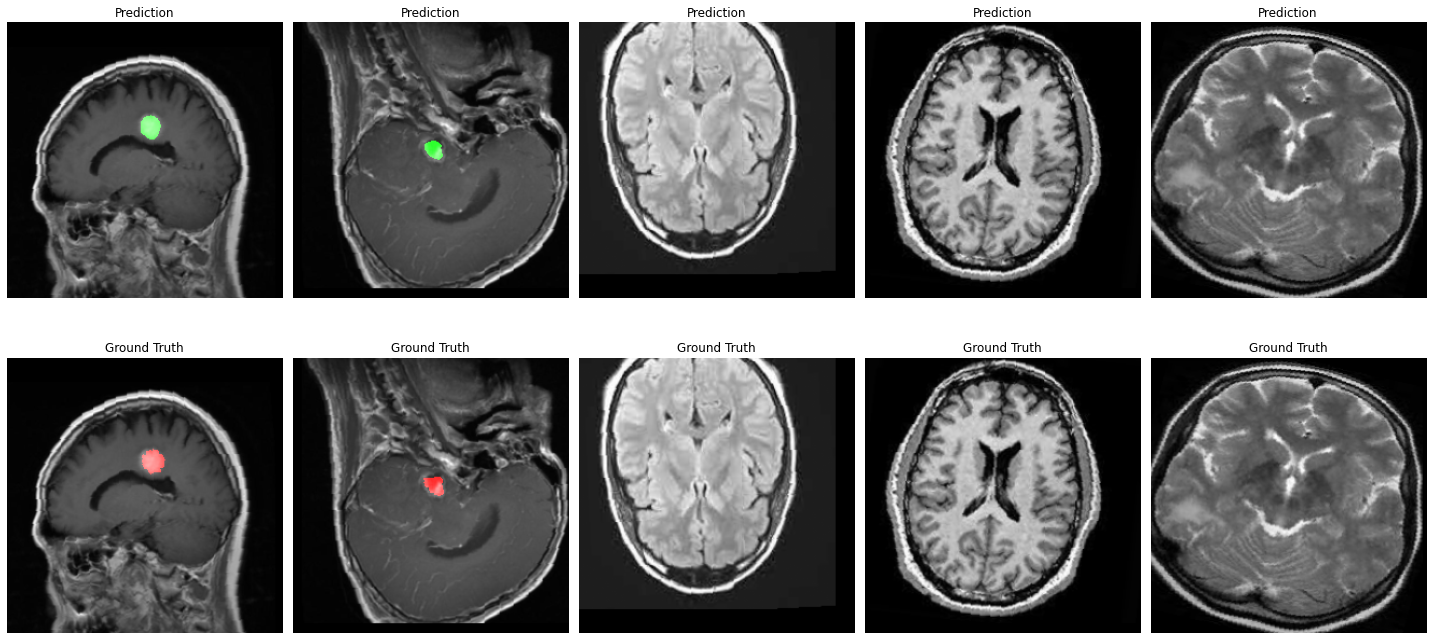

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_overlay_predictions(model, dataset, device, num_images=5, alpha=0.5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    
    with torch.no_grad():
        fig, axes = plt.subplots(2, num_images, figsize=(20, 10))
        for i, idx in enumerate(indices):
            # Load image and mask from dataset
            image, mask = dataset[idx]
            image = image.unsqueeze(0).to(device)
            
            # Predict mask
            pred_mask = model(image)
            pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()  # Get the class with the highest probability
            
            # Convert tensors to numpy arrays
            image_np = image.squeeze().cpu().numpy()
            mask_np = mask.squeeze().cpu().numpy()
            
            # Normalize image for better visualization (if needed)
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            
            # Overlay predicted mask on the image
            overlay_pred = np.stack([image_np, image_np, image_np], axis=-1)
            overlay_pred[..., 1] = np.where(pred_mask == 1, 1, overlay_pred[..., 1])  # Green for predicted mask
            
            # Overlay original mask on the image
            overlay_mask = np.stack([image_np, image_np, image_np], axis=-1)
            overlay_mask[..., 0] = np.where(mask_np == 1, 1, overlay_mask[..., 0])  # Red for ground truth mask
            
            # Display the overlay prediction
            axes[0, i].imshow(overlay_pred)
            axes[0, i].set_title('Prediction')
            axes[0, i].axis('off')
            
            # Display the overlay ground truth
            axes[1, i].imshow(overlay_mask)
            axes[1, i].set_title('Ground Truth')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Visualize overlay predictions
visualize_overlay_predictions(model, test_dataset, device, num_images=5, alpha=0.5)
